## Modeling for predicting critical outcome at ED triage

Work Flow:
1. Task-specific filter
2. Variable selection
3. Modeling script
4. Performance output


### Load train and test

In [1]:
import os
import time
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import load_model
from helpers_for_tasks import PlotROCCurve


output_path = 'D:\\1_Teaching_Work_Folder\\SMU\\MITB_HealthcareAnalytics\\Group_Project\\Uploaded_Git\\output_2023'

df_train = pd.read_csv((os.path.join(path, 'train2.csv')))
df_test = pd.read_csv((os.path.join(path, 'test2.csv')))
confidence_interval = 95
random_seed = 0

In [2]:
pd.set_option('display.max_columns', 100) 
pd.set_option('display.max_rows', 100) 

df_train.head()

,index,subject_id,hadm_id,stay_id,intime,outtime,anchor_age,gender,anchor_year,dod,admittime,dischtime,deathtime,race,edregtime,edouttime,insurance,in_year,age,before_ed_mortality,outcome_hospitalization,outcome_inhospital_mortality,ed_death,ed_los,intime_icu,time_to_icu_transfer,outcome_icu_transfer_12h,outcome_critical,n_ed_30d,n_ed_90d,n_ed_365d,next_ed_visit_time,next_ed_visit_time_diff,outcome_ed_revisit_3d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,ed_los_hours,time_to_icu_transfer_hours,next_ed_visit_time_diff_days,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,triage_pain,...,cci_Liver2,cci_Cancer2,cci_HIV,eci_CHF,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_PVD,eci_HTN1,eci_HTN2,eci_Paralysis,eci_NeuroOther,eci_Pulmonary,eci_DM1,eci_DM2,eci_Hypothyroid,eci_Renal,eci_Liver,eci_PUD,eci_HIV,eci_Lymphoma,eci_Tumor2,eci_Tumor1,eci_Rheumatic,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression,ed_temperature_last,ed_heartrate_last,ed_resprate_last,ed_o2sat_last,ed_sbp_last,ed_dbp_last,ed_pain_last,n_med,n_medrecon,triage_MAP,score_CCI,score_CART,score_REMS,score_NEWS,score_NEWS2,score_MEWS
0,273532,18971123,21753872.0,37200982,2149-07-15 22:41:00,2149-07-16 06:27:00,45.0,F,2149.0,NaN,2149-07-16 04:10:00,2149-07-28 18:37:00,NaN,WHITE,2149-07-15 22:41:00,2149-07-16 06:27:00,Other,2149,45.0,False,True,False,False,0 days 07:46:00,NaN,NaN,False,False,0,1,1,2149-08-01 14:27:00,16 days 08:00:00,False,0,0,0,0,0,0,7.77,NaN,16.33,37.444444,102.0,19.0,100.0,133.0,88.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.333333,72.0,16.0,100.0,165.0,105.0,0.0,3.0,1.0,103.000000,0,0,2,1,1,2
1,253777,15439233,NaN,31867345,2159-12-20 19:43:00,2159-12-20 19:59:00,18.0,M,2159.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2159,18.0,False,False,False,False,0 days 00:16:00,NaN,NaN,False,False,0,0,0,2160-02-11 01:14:00,52 days 05:15:00,False,0,0,0,0,0,0,0.27,NaN,52.22,37.111111,70.0,20.0,99.0,151.0,64.0,7.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.666667,60.0,16.0,100.0,132.0,70.0,7.0,1.0,0.0,93.000000,0,0,0,0,0,1
2,365291,15341533,NaN,30037900,2171-09-02 21:24:00,2171-09-02 21:27:00,40.0,F,2171.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2171,40.0,False,False,False,False,0 days 00:03:00,NaN,NaN,False,False,0,0,0,NaN,NaN,False,0,0,0,0,0,0,0.05,NaN,NaN,37.555556,97.0,16.0,97.0,120.0,70.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,37.555556,95.0,18.0,98.0,113.0,67.0,0.0,0.0,0.0,86.666667,0,0,0,1,1,1
3,76261,13512582,NaN,38777853,2131-11-08 22:59:00,2131-11-08 23:04:00,70.0,F,2131.0,NaN,NaN,NaN,NaN,HISPANIC/LATINO - PUERTO RICAN,NaN,NaN,NaN,2131,70.0,False,False,False,False,0 days 00:05:00,NaN,NaN,False,False,0,0,0,2137-11-14 18:47:00,2197 days 19:43:00,False,0,0,0,0,0,0,0.08,NaN,2197.82,37.000000,58.0,16.0,100.0,155.0,44.0,10.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,37.111111,51.0,18.0,96.0,173.0,63.0,2.0,3.0,2.0,81.000000,3,13,7,0,0,1
4,99718,17758321,NaN,35942414,2115-06-25 13:15:00,2115-06-25 13:38:00,50.0,M,2115.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2115,50.0,False,False,False,False,0 days 00:23:00,NaN,NaN,False,False,1,1,1,NaN,NaN,False,0,0,0,0,0,0,0.38,NaN,NaN,36.555556,72.0,16.0,96.0,187.0,108.0,6.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.777778,62.0,16.0,100.0,161.0,99.0,0.0,1.0,2.0,134.333333,1,0,5,0,0,1


### 1. task-specific filter

In [3]:
df_train = df_train[df_train['ed_death'] == False]
df_test = df_test[df_test['ed_death'] == False].reset_index()

### 2. Variable Selection

In [4]:
variable = ["age", "gender", 
            
            "n_ed_30d", "n_ed_90d", "n_ed_365d", "n_hosp_30d", "n_hosp_90d", 
            "n_hosp_365d", "n_icu_30d", "n_icu_90d", "n_icu_365d", 
            
            "triage_temperature", "triage_heartrate", "triage_resprate", 
            "triage_o2sat", "triage_sbp", "triage_dbp", "triage_pain", "triage_acuity",
            
            "chiefcom_chest_pain", "chiefcom_abdominal_pain", "chiefcom_headache",
            "chiefcom_shortness_of_breath", "chiefcom_back_pain", "chiefcom_cough", 
            "chiefcom_nausea_vomiting", "chiefcom_fever_chills", "chiefcom_syncope", 
            "chiefcom_dizziness", 
            
            "cci_MI", "cci_CHF", "cci_PVD", "cci_Stroke", "cci_Dementia", 
            "cci_Pulmonary", "cci_Rheumatic", "cci_PUD", "cci_Liver1", "cci_DM1", 
            "cci_DM2", "cci_Paralysis", "cci_Renal", "cci_Cancer1", "cci_Liver2", 
            "cci_Cancer2", "cci_HIV", 
            
            "eci_Arrhythmia", "eci_Valvular", "eci_PHTN",  "eci_HTN1", "eci_HTN2", 
            "eci_NeuroOther", "eci_Hypothyroid", "eci_Lymphoma", "eci_Coagulopathy", 
            "eci_Obesity", "eci_WeightLoss", "eci_FluidsLytes", "eci_BloodLoss",
            "eci_Anemia", "eci_Alcohol", "eci_Drugs","eci_Psychoses", "eci_Depression"]

outcome = "outcome_critical"

In [5]:
X_train = df_train[variable].copy()
y_train = df_train[outcome].copy()
X_test = df_test[variable].copy()
y_test = df_test[outcome].copy()

In [6]:
X_train.dtypes.to_frame().T

,age,gender,n_ed_30d,n_ed_90d,n_ed_365d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,triage_pain,triage_acuity,chiefcom_chest_pain,chiefcom_abdominal_pain,chiefcom_headache,chiefcom_shortness_of_breath,chiefcom_back_pain,chiefcom_cough,chiefcom_nausea_vomiting,chiefcom_fever_chills,chiefcom_syncope,chiefcom_dizziness,cci_MI,cci_CHF,cci_PVD,cci_Stroke,cci_Dementia,cci_Pulmonary,cci_Rheumatic,cci_PUD,cci_Liver1,cci_DM1,cci_DM2,cci_Paralysis,cci_Renal,cci_Cancer1,cci_Liver2,cci_Cancer2,cci_HIV,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_HTN1,eci_HTN2,eci_NeuroOther,eci_Hypothyroid,eci_Lymphoma,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression
0,float64,object,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64


In [7]:
encoder = LabelEncoder()
X_train['gender'] = encoder.fit_transform(X_train['gender'])
X_test['gender'] = encoder.transform(X_test['gender'])

In [8]:
print('class ratio')
ratio = y_train.sum()/(~y_train).sum()
print('positive : negative =', ratio, ': 1')

class ratio
positive : negative = 0.06275673965130121 : 1


### 3.  Modeling script

In [9]:
# Containers for all results
result_list = []

Logistic Regression:


c:\Users\Sean Lam\.conda\envs\snowflakes\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training time: 5.63245701789856 seconds
AUC: 0.8690513472048608
AUPRC: 0.3393840603018713
Sensitivity: 0.7980805419646217
Specificity: 0.782685320425383
Score thresold: 0.06465598560583642
2.5 97.5


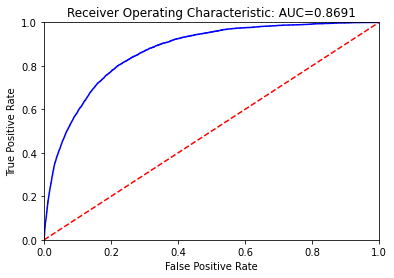

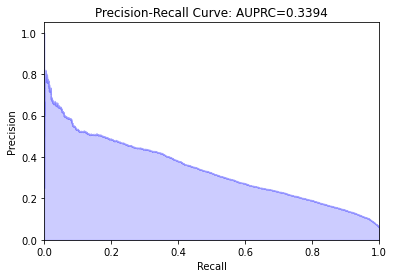

In [10]:
print("Logistic Regression:")
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression(random_state=random_seed)
start = time.time()
logreg.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = logreg.predict_proba(X_test)
result = PlotROCCurve(probs[:,1], y_test, ci=confidence_interval, random_seed=random_seed)

results = ["LR"]
results.extend(result)
results.append(runtime)
result_list.append(results)

RandomForest:
Training time: 74.42380714416504 seconds
AUC: 0.8772470468021569
AUPRC: 0.38843777078168795
Sensitivity: 0.8050432818968761
Specificity: 0.7910746834373453
Score thresold: 0.07423076923076924
2.5 97.5


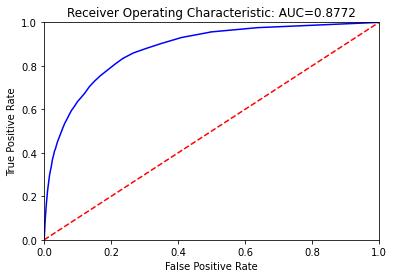

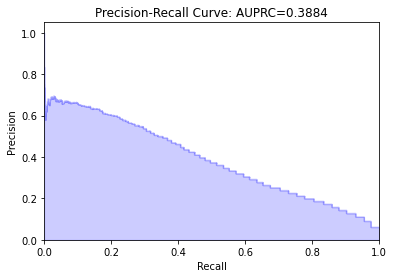

[0.10012345 0.01486062 0.00632107 0.01032946 0.01903617 0.00625429
 0.00991474 0.01708656 0.0031992  0.00680667 0.01191883 0.07668977
 0.09310427 0.05524303 0.05086902 0.10039599 0.08496407 0.04028525
 0.09044299 0.00600395 0.0063601  0.00398831 0.00160951 0.00218083
 0.00250239 0.00318669 0.00480524 0.00333055 0.00297592 0.00506803
 0.00568981 0.00503119 0.00501668 0.00288587 0.00738628 0.00273669
 0.00271886 0.00471666 0.00752813 0.00488779 0.00248265 0.00503001
 0.00532702 0.00305692 0.00380259 0.00112122 0.00707785 0.004627
 0.0045018  0.0050036  0.00891977 0.00577691 0.00557678 0.00181228
 0.00556789 0.00552274 0.00465367 0.00688942 0.00223529 0.00458001
 0.0047687  0.00366334 0.00258585 0.0069617 ]


In [11]:
print("RandomForest:")
from sklearn.ensemble import RandomForestClassifier
rf= RandomForestClassifier(random_state=random_seed)
start = time.time()
rf.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = rf.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)
importances = rf.feature_importances_
print(importances)

results = ["RF"]
results.extend(result)
results.append(runtime)
result_list.append(results)

GradientBoosting:
Training time: 73.76055788993835 seconds
AUC: 0.8829724395671947
AUPRC: 0.40869193377349544
Sensitivity: 0.7980805419646217
Specificity: 0.8053788491483891
Score thresold: 0.0699128930806098
2.5 97.5


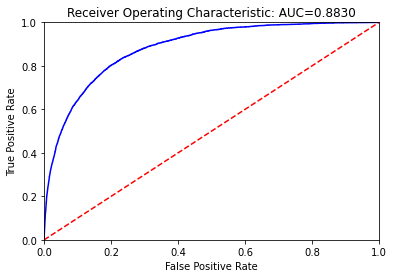

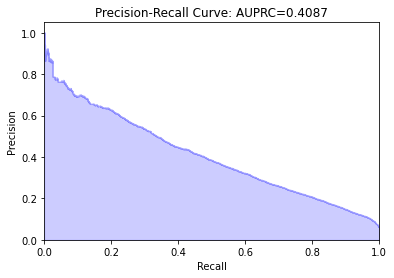

In [12]:
print("GradientBoosting:")
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=random_seed)
start = time.time()
gb.fit(X_train, y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = gb.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

results = ["GB"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [13]:
class MLP(tf.keras.Model):
    def __init__(self):
        super(MLP, self).__init__()
        self.dense_1 = Dense(128, activation='relu')
        self.dense_2 = Dense(64, activation='relu')
        self.classifier = Dense(1, activation='sigmoid')

    def call(self, x):
        x = self.dense_1(x)
        x = self.dense_2(x)
        return self.classifier(x)

In [14]:
# skip this cell if not retraining
mlp = MLP()
mlp.compile(loss='binary_crossentropy', 
              optimizer=optimizers.Adam(learning_rate=0.001), 
              metrics=['accuracy', 'AUC', {'auprc': metrics.AUC(name='auprc', curve='PR')}, 
                       'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
start = time.time()
mlp.fit(X_train.astype(np.float32), y_train, batch_size=200, epochs=20)
runtime = time.time() - start
print('Training time:', runtime, 'seconds')
mlp.save('critical_triage_mlp')

Epoch 1/20
1764/1764 [==============================] - 2s 911us/step - loss: 0.2241 - accuracy: 0.9392 - auc: 0.7937 - auprc: 0.2296 - true_positives: 1768.0000 - true_negatives: 329437.0000 - precision: 0.4275 - recall: 0.0849
Epoch 2/20
1764/1764 [==============================] - 2s 1ms/step - loss: 0.1717 - accuracy: 0.9417 - auc: 0.8526 - auprc: 0.3193 - true_positives: 2801.0000 - true_negatives: 329274.0000 - precision: 0.5253 - recall: 0.1345
Epoch 3/20
1764/1764 [==============================] - 2s 1ms/step - loss: 0.1675 - accuracy: 0.9424 - auc: 0.8628 - auprc: 0.3350 - true_positives: 2810.0000 - true_negatives: 329522.0000 - precision: 0.5517 - recall: 0.1349
Epoch 4/20
1764/1764 [==============================] - 2s 939us/step - loss: 0.1651 - accuracy: 0.9427 - auc: 0.8680 - auprc: 0.3459 - true_positives: 2802.0000 - true_negatives: 329634.0000 - precision: 0.5634 - recall: 0.1346
Epoch 5/20
1764/1764 [==============================] - 2s 1ms/step - loss: 0.1644 - acc

MLP:
AUC: 0.8834644485866543
AUPRC: 0.39560842143562475
Sensitivity: 0.8125705683101242
Specificity: 0.7918593001219174
Score thresold: 0.06273815
2.5 97.5


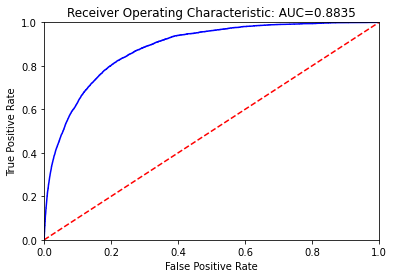

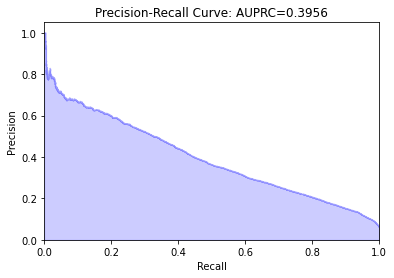

In [15]:
print("MLP:")
mlp = load_model('critical_triage_mlp')
probs = mlp.predict(X_test.astype(np.float32))
result = PlotROCCurve(probs,y_test, ci=confidence_interval, random_seed=random_seed)
results = ["MLP"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [16]:
def get_score_performance(s, random_seed=0):
    print(s)
    score = np.array(df_test[s])
    result = PlotROCCurve(score,y_test, ci=confidence_interval, random_seed=random_seed)
    runtime = 0
    results = [s]
    results.extend(result)
    results.append(runtime)
    result_list.append(results)


score_NEWS
AUC: 0.6370474205187568
AUPRC: 0.16191181454987127
Sensitivity: 0.4685735792246895
Specificity: 0.7938510193981386
Score thresold: 2
2.5 97.5


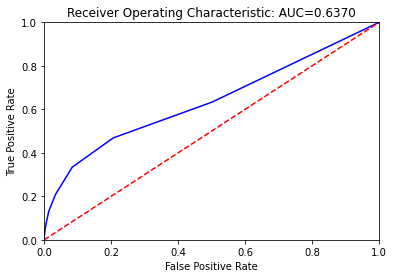

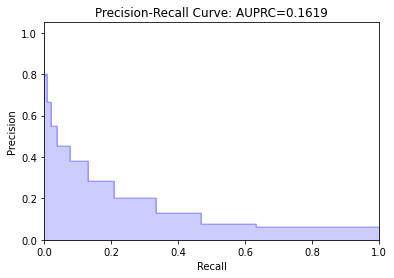

In [17]:
get_score_performance("score_NEWS", random_seed=random_seed)

score_NEWS2
AUC: 0.6220120570695026
AUPRC: 0.1466079878850494
Sensitivity: 0.41889348889725253
Specificity: 0.8218678705503181
Score thresold: 2
2.5 97.5


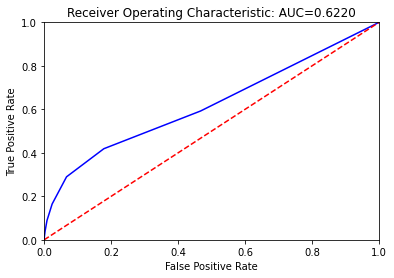

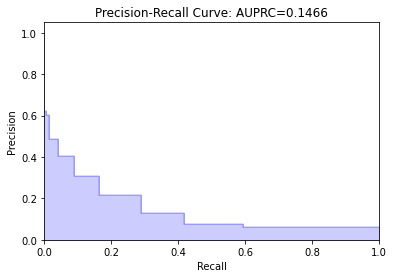

In [18]:
get_score_performance("score_NEWS2", random_seed=random_seed)

score_REMS
AUC: 0.6885579613070328
AUPRC: 0.11142118198198758
Sensitivity: 0.6827248776815957
Specificity: 0.6131960455319098
Score thresold: 5
2.5 97.5


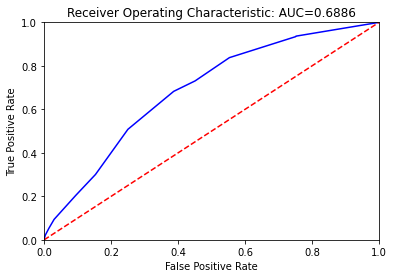

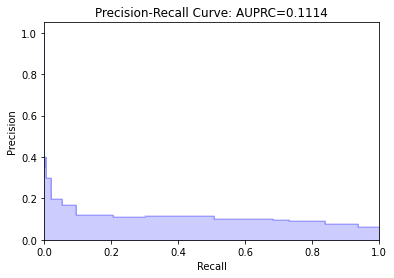

In [19]:
get_score_performance("score_REMS", random_seed=random_seed)

score_MEWS
AUC: 0.6202693350724213
AUPRC: 0.11688226125695778
Sensitivity: 0.44373353406097105
Specificity: 0.7714592663230448
Score thresold: 2
2.5 97.5


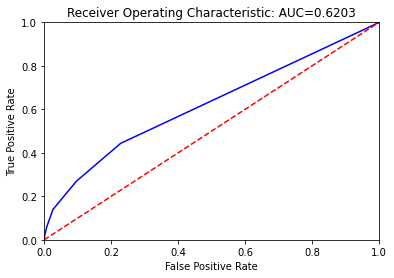

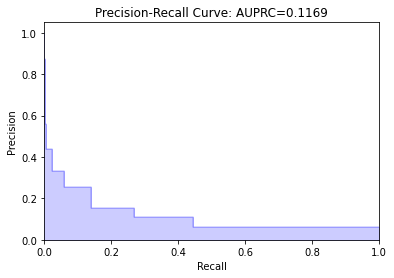

In [20]:
get_score_performance("score_MEWS", random_seed=random_seed)

### 4. Performance output

In [21]:
result_df = pd.DataFrame(result_list, columns=['Model', 'auroc', 'ap', 'sensitivity', 'specificity', 'threshold', 
                                               'lower_auroc', 'upper_auroc', 'std_auroc', 'lower_ap', 'upper_ap', 
                                               'std_ap', 'lower_sensitivity', 'upper_sensitivity', 'std_sensitivity', 
                                               'lower_specificity', 'upper_specificity', 'std_specificity', 'runtime'])
result_df.to_csv(os.path.join(path, 'result_critical_triage.csv'), index=False)

result_df = result_df.round(3)
formatted_result_df = pd.DataFrame()
formatted_result_df[['Model', 'Threshold']] = result_df[['Model', 'threshold']]
formatted_result_df['AUROC'] = result_df['auroc'].astype(str) + ' (' + result_df['lower_auroc'].astype(str) + \
                               '-' + result_df['upper_auroc'].astype(str) + ')'
formatted_result_df['AUPRC'] = result_df['ap'].astype(str) + ' (' + result_df['lower_ap'].astype(str) + \
                               '-' + result_df['upper_ap'].astype(str) + ')'
formatted_result_df['Sensitivity'] = result_df['sensitivity'].astype(str) + ' (' + result_df['lower_sensitivity'].astype(str) + \
                                     '-' + result_df['upper_sensitivity'].astype(str) + ')'
formatted_result_df['Specificity'] = result_df['specificity'].astype(str) + ' (' + result_df['lower_specificity'].astype(str) + \
                                     '-' + result_df['upper_specificity'].astype(str) + ')'
formatted_result_df[['Runtime']] = result_df[['runtime']]
formatted_result_df.to_csv(os.path.join(path, 'task2.csv'), index=False)
formatted_result_df

,Model,Threshold,AUROC,AUPRC,Sensitivity,Specificity,Runtime
0,LR,0.065,0.869 (0.866-0.872),0.339 (0.331-0.35),0.798 (0.789-0.811),0.783 (0.776-0.792),5.632
1,RF,0.074,0.877 (0.875-0.881),0.388 (0.379-0.404),0.805 (0.8-0.84),0.791 (0.765-0.794),74.424
2,GB,0.070,0.883 (0.881-0.886),0.409 (0.399-0.42),0.798 (0.794-0.818),0.805 (0.784-0.808),73.761
3,MLP,0.063,0.883 (0.881-0.886),0.396 (0.384-0.408),0.813 (0.796-0.82),0.792 (0.782-0.805),35.276
4,score_NEWS,2.000,0.637 (0.629-0.644),0.162 (0.154-0.168),0.469 (0.456-0.481),0.794 (0.792-0.797),0.000
5,score_NEWS2,2.000,0.622 (0.614-0.63),0.147 (0.14-0.152),0.419 (0.407-0.432),0.822 (0.82-0.825),0.000
6,score_REMS,5.000,0.689 (0.683-0.693),0.111 (0.108-0.114),0.683 (0.676-0.693),0.613 (0.61-0.617),0.000
7,score_MEWS,2.000,0.62 (0.614-0.627),0.117 (0.112-0.122),0.444 (0.432-0.458),0.771 (0.769-0.774),0.000


In [22]:
importance_df = pd.DataFrame(zip(variable, importances), columns=['Variable','Importance'])
importance_df.to_csv(os.path.join(path, 'importances_critical_triage.csv'))
importance_df.sort_values(by='Importance', axis=0,ascending=False)

,Variable,Importance
15,triage_sbp,0.100396
0,age,0.100123
12,triage_heartrate,0.093104
18,triage_acuity,0.090443
16,triage_dbp,0.084964
11,triage_temperature,0.076690
13,triage_resprate,0.055243
14,triage_o2sat,0.050869
17,triage_pain,0.040285
4,n_ed_365d,0.019036
